## Fake news classification (kaggle)

#### Source: https://www.kaggle.com/c/fake-news
The Project is designed to analyze and classify news sources
for authenticity and accuracy

##### Steps involved in deep learning RNN analysis

- Read the text and classification label
- Tokenize the text and clean
- Perform word embedding
- Train RNN/LSTM model



###### References:

###### - https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
- https://github.com/msahamed/yelp_comments_classification_nlp
###### - https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47
- https://github.com/nsinha280/lstm-on-Yelp-review-data/blob/master/lstm-final.ipynb

In [1]:
## Input libraries

## system libraries

import os
import sys
import glob
import re

## analysis libraries

import pandas as pd
import numpy as np


## text and language processing
from langdetect import detect
import string
#from string import punctuation
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')

from nltk.corpus import stopwords

from sklearn.manifold import TSNE
## Keras
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Bidirectional
from keras.layers.embeddings import Embedding


## plotting
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
%matplotlib inline



Using TensorFlow backend.


In [2]:
## Data source and files

dir_data = r'data'

file_train = r'data/train.csv'
file_train_clean = r'train_clean.tsv'
file_test = r'data/test.csv'

In [3]:
#### Train Data summary

train_all_df = pd.read_csv(file_train)

print(train_all_df.shape)
train_all_df.head()

(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


#### Remove empty articles

In [4]:
## remove empty cells
train_all_df = train_all_df[train_all_df.text.apply(lambda x: x !="")]

print(train_all_df.shape)

(20800, 5)


In [5]:
## replace empty cells with NAN and remove rows with NA
train_all_df['text'].replace('', np.nan, inplace=True)

train_all_df.dropna(inplace=True,subset=['text','label'])

train_all_df['text'].isnull().sum()

print(train_all_df.shape)

(20761, 5)


In [22]:
## summary of article labels by author and text
#article_type_count = train_all_df[['author','label','text']].groupby(['label']).count().plot.bar(fontsize=20,figsize=(18, 9))

article_type_count = train_all_df[['author','label','text']].groupby(['label']).count()
article_type_count.reset_index(level=0, inplace=True)

## melt dataframe
melted = pd.melt(article_type_count,id_vars='label')

melted

,label,variable,value
0,0,author,10361
1,1,author,8482
2,0,text,10387
3,1,text,10374


C:\Anaconda\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


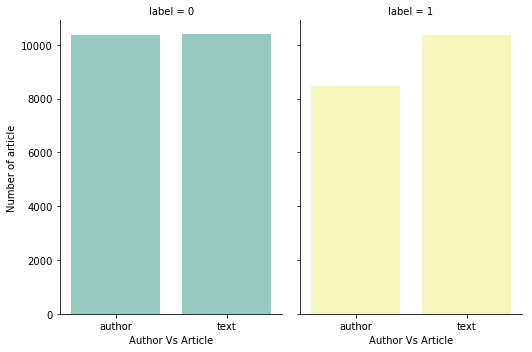

In [49]:
## plot barplot with seaborn


g = sns.FacetGrid(melted, col="label",hue="label",palette="Set3",size=5, aspect=0.75)
g.map(sns.barplot,'variable','value')\
.set_axis_labels("Author Vs Article", "Number of article")

In [11]:
train_all_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [41]:
### Detect the language of the text article in a list

def lang_detect_list(list_docs):
    """
    Check if txt exit, Check lang
    else, print n lang
    """
    lang = []
    for obj in list_docs:
        obj = obj[:100]
        if re.search('\w',obj):
        #if isinstance(obj, str) and obj is not None:
            #print('obj is a string!')
            #print(detect(obj)) # for x in train_all_df['text'][:10]]
            try:
                lang_str = detect(obj)
            except:
                lang_str = 'exception'
            
            lang.append(lang_str)

        else:
            lang.append('NoString')
            
    return(lang)

In [42]:
#train_all_df.
#lang_detect_list(train_all_df['text'][:200])

lang_list = lang_detect_list(train_all_df['text'])

In [43]:
## add the language as a column 
train_all_df['lang'] = lang_detect_list(train_all_df['text'])

In [44]:
train_all_df.head()

,id,title,author,text,label,lang
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,en
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,en
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,en
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,en
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,en


In [45]:
## write the modified data as a file
out_file = dir_data + '/' + file_train_clean
train_all_df.to_csv(out_file,sep='\t')


In [46]:
## Languages for articles

lang_label_summary = train_all_df[['lang','label','author']].groupby(['lang','label']).agg('count').reset_index()

lang_label_summary.head()

,lang,label,author
0,NoString,1,75
1,af,0,1
2,af,1,3
3,ar,1,4
4,ca,1,7


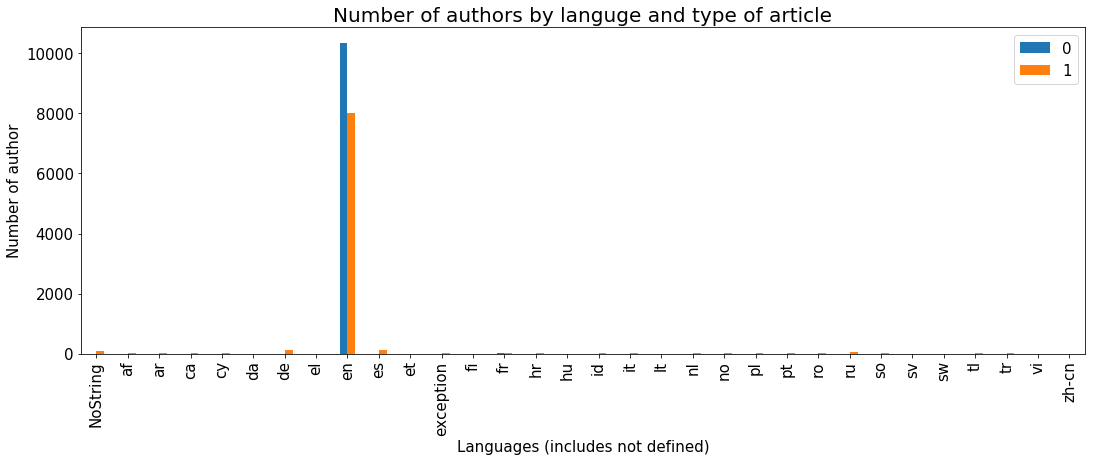

In [63]:
## plot the number of articles by language and article type

ax = lang_label_summary.pivot(index='lang',columns='label',values='author').plot.bar(fontsize=15,figsize=(18, 6))

ax.set_xlabel("Languages (includes not defined)",fontsize=15)
ax.set_ylabel("Number of author",fontsize=15)
ax.set_title('Number of authors by languge and type of article',fontsize= 20) 
ax.legend(fontsize=15)

#### Tokenize the text and clean

In [7]:

df_all = train_all_df[['text','label']]

### select rows
#df = df_all.iloc[0:500]
#labels =
df = df_all

### Create sequence
vocabulary_size = 20000

tokenizer = Tokenizer(num_words= vocabulary_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,split=' ')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
data_all = pad_sequences(sequences, maxlen=50)

In [67]:
data = data_all[:15000]
label = df.iloc[:15000,1]
len(data)
#print(data[:10])

15000

#### Build the word embedding LSTM model 1

In [68]:
## Network architecture
embeding_size = 128

model1 = Sequential()
model1.add(Embedding(20000, embeding_size, input_length=50))
model1.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Show the model
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 128)           2560000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 150)               167400    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 151       
Total params: 2,727,551
Trainable params: 2,727,551
Non-trainable params: 0
_________________________________________________________________


#### Run the model

In [69]:
## Fit the model
model1.fit(data, np.array(label), validation_split=0.2, epochs=10)

Train on 12000 samples, validate on 3000 samples
Epoch 1/10
12000/12000 [==============================] - 64s 5ms/step - loss: 0.3279 - acc: 0.8570 - val_loss: 0.2593 - val_acc: 0.8880
Epoch 2/10
12000/12000 [==============================] - 69s 6ms/step - loss: 0.1395 - acc: 0.9494 - val_loss: 0.2639 - val_acc: 0.9027
Epoch 3/10
12000/12000 [==============================] - 71s 6ms/step - loss: 0.0659 - acc: 0.9790 - val_loss: 0.3727 - val_acc: 0.8807
Epoch 4/10
12000/12000 [==============================] - 69s 6ms/step - loss: 0.0365 - acc: 0.9883 - val_loss: 0.3664 - val_acc: 0.8907
Epoch 5/10
12000/12000 [==============================] - 66s 6ms/step - loss: 0.0193 - acc: 0.9948 - val_loss: 0.4515 - val_acc: 0.8873
Epoch 6/10
12000/12000 [==============================] - 67s 6ms/step - loss: 0.0140 - acc: 0.9952 - val_loss: 0.4626 - val_acc: 0.8767
Epoch 7/10
12000/12000 [==============================] - 67s 6ms/step - loss: 0.0087 - acc: 0.9976 - val_loss: 0.5102 - val_acc:

#### Evaluate the model

In [70]:
## Evaluate the model
X_test = data_all[15000:20500]
Y_test =  df.iloc[15000:20500,1]

In [71]:

score,acc  =  model1.evaluate(X_test, Y_test, verbose = 2)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 0.53
Validation Accuracy: 0.88


prediction_sigmoid 

In [72]:
## Prediction of the labels

prediction_sigmoid = model1.predict(X_test, verbose = 2)

In [73]:
## Convert prediction (floats) to integer and compile predictions

print(prediction_sigmoid.shape)

predict_sigmoid_round = prediction_sigmoid.round()

#print(predict_sigmoid_round)

print(np.reshape(predict_sigmoid_round,len(predict_sigmoid_round)).shape)

predicted_label = list(np.reshape(predict_sigmoid_round,len(predict_sigmoid_round)))

(5500, 1)
(5500,)


In [74]:
## Compute the TP, TN, FP, FN values

def get_matrics_binary(Y_original,Y_prediction):
    """
    Input list of original and preidcted labels 
    for binary classifiers (0,1)
    """
    Y_original = np.asarray(Y_original)
    Y_prediction = np.asarray(Y_prediction)
    
    if len(Y_original) == len(Y_prediction):
        ## TP
        TP = np.sum(np.logical_and(Y_original == 1, Y_prediction == 1)) 
        
        ## FP
        TN = np.sum(np.logical_and(Y_original == 0, Y_prediction == 0))
        
        ## 
        FP = np.sum(np.logical_and(Y_original == 0, Y_prediction == 1)) 
        
        ## FP
        FN = np.sum(np.logical_and(Y_original == 1, Y_prediction == 0))
        
    return(TP,TN,FP,FN)




#### Evaluation matrices

- Precision 
- Recall
- F1-score


In [75]:
TP,TN,FP,FN = get_matrics_binary(Y_test,predicted_label)

In [76]:
## Calculate TP, TN, FP, FN, Precision, Recall and F1 score
def get_prec_recall_f1(TP,TN,FP,FN):
    """
    Input provide the values for TP,TN,FP,FN
    Output: get the precision, recall and the F1 score
    """
    ## Calculate precision and recall
    recall = float(TP)/(TP + FN)
    precision = float(TP)/(TP + FP)

    print("Recall: {}, Precision: {}".format(recall, precision))
    
    ## Calculate F-score using the formula with beta = 0.5
    beta = 0.5
    fscore = (1 + beta**2) * (precision * recall)/((beta**2)*precision + recall)
    # Print the results 
    print("F-score: {}".format(fscore))

In [77]:
get_prec_recall_f1(TP,TN,FP,FN)

Recall: 0.8861404146962532, Precision: 0.8791050162396247
F-score: 0.8805031446540881


#### Build the word embedding bidirectional LSTM model 2

In [78]:
## Network architecture
embeding_size = 128

model2 = Sequential()
model2.add(Embedding(20000, embeding_size, input_length=50))
model2.add(Bidirectional(LSTM(150, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Show the model
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 128)           2560000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 300)               334800    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 301       
Total params: 2,895,101
Trainable params: 2,895,101
Non-trainable params: 0
_________________________________________________________________


In [79]:
## Fit the model
model2.fit(data, np.array(label), validation_split=0.2, epochs=10)

Train on 12000 samples, validate on 3000 samples
Epoch 1/10
12000/12000 [==============================] - 118s 10ms/step - loss: 0.3254 - acc: 0.8603 - val_loss: 0.2679 - val_acc: 0.8883
Epoch 2/10
12000/12000 [==============================] - 112s 9ms/step - loss: 0.1226 - acc: 0.9559 - val_loss: 0.2423 - val_acc: 0.8973
Epoch 3/10
12000/12000 [==============================] - 113s 9ms/step - loss: 0.0608 - acc: 0.9814 - val_loss: 0.3153 - val_acc: 0.8930
Epoch 4/10
12000/12000 [==============================] - 115s 10ms/step - loss: 0.0320 - acc: 0.9909 - val_loss: 0.3687 - val_acc: 0.8970
Epoch 5/10
12000/12000 [==============================] - 114s 10ms/step - loss: 0.0157 - acc: 0.9957 - val_loss: 0.5206 - val_acc: 0.8900
Epoch 6/10
12000/12000 [==============================] - 115s 10ms/step - loss: 0.0116 - acc: 0.9968 - val_loss: 0.4945 - val_acc: 0.8923
Epoch 7/10
12000/12000 [==============================] - 114s 9ms/step - loss: 0.0090 - acc: 0.9977 - val_loss: 0.5277

In [80]:
## Evaluation of model 2


score,acc  =  model2.evaluate(X_test, Y_test, verbose = 2)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 0.52
Validation Accuracy: 0.89


In [81]:
## Prediction of the labels

prediction_sigmoid = model2.predict(X_test, verbose = 2)

## Convert prediction (floats) to integer and compile predictions

print(prediction_sigmoid.shape)

predict_sigmoid_round = prediction_sigmoid.round()

#print(predict_sigmoid_round)

print(np.reshape(predict_sigmoid_round,len(predict_sigmoid_round)).shape)

predicted_label = list(np.reshape(predict_sigmoid_round,len(predict_sigmoid_round)))

(5500, 1)
(5500,)


In [82]:
## Evaluation matrics

TP,TN,FP,FN = get_matrics_binary(Y_test,predicted_label)

get_prec_recall_f1(TP,TN,FP,FN)

Recall: 0.8752273554019644, Precision: 0.8940914158305463
F-score: 0.8902538296455267


### Compare with Deeplearning results with Naive bayes benchmark method

## In Progress

#### Testing code

In [19]:
## adapted from https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b

### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    """
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    """
    return text


In [10]:
## apply the above function to df['text']
train_all_df['text'] = train_all_df['text'].map(lambda x: clean_text(x))

NameError: name 'clean_text' is not defined

In [21]:
print(train_all_df.shape)
train_all_df.head()

(20761, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,house dem aide : didn t even see comey s lette...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,ever get feeling life circles roundabout rathe...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,truth might get fired october 29 2016 + the te...,1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,videos civilians killed single airstrike ident...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,print + an iranian woman sentenced six years p...,1


#### Tokenize and clean documents (NLTK)

In [22]:
#example_sent = "This is a sample sentence, showing off the stop words filtration."

stop_words = set(stopwords.words('english'))


def tokenize_words_nltk(input_text):
    """
    Input a text string
    - tokenize the words
    - make lower case
    - remove stop words
    - remove punctuations
    
    Otput the list of clean text string
    """
    
    ## make text lower case
    input_text = input_text.lower()

    ## tokenize text to words
    word_tokens = word_tokenize(input_text)

    ## filter for stop words
    word_filtered = [w for w in word_tokens if not w in stop_words]
    
    return(word_filtered)

In [23]:
train_all_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,house dem aide : didn t even see comey s lette...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,ever get feeling life circles roundabout rathe...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,truth might get fired october 29 2016 + the te...,1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,videos civilians killed single airstrike ident...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,print + an iranian woman sentenced six years p...,1


#### Summary statistics

In [7]:
## remove empty cells
train_all_df = train_all_df[train_all_df.text.apply(lambda x: x !="")]

print(train_all_df.shape)

(20761, 5)


In [8]:
## replace empty cells with NAN and remove rows with NA
train_all_df['text'].replace('', np.nan, inplace=True)

train_all_df.dropna(inplace=True,subset=['text','label'])

train_all_df['text'].isnull().sum()

print(train_all_df.shape)

(20761, 5)


In [9]:
train_all_df[['author','label','text']].groupby(['label']).count()

,author,text
label,,
0,10361,10387
1,8482,10374


In [10]:
print(train_all_df.shape)

(20761, 5)


In [11]:
train_all_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [12]:
### Function to remove punctuations

def remove_punctuation(text_str):
    """
    Takes a string input of a short article
    Outputs a string without any punctuations.
    """


In [13]:
### Detect the language of the text article in a list

def lang_detect_list(list_docs):
    """
    Check if txt exit, Check lang
    else, print n lang
    """
    lang = []
    for obj in list_docs:
        obj = obj[:100]
        if re.search('\w',obj):
        #if isinstance(obj, str) and obj is not None:
            #print('obj is a string!')
            #print(detect(obj)) # for x in train_all_df['text'][:10]]
            try:
                lang_str = detect(obj)
            except:
                lang_str = 'exception'
            
            lang.append(lang_str)

        else:
            lang.append('NoString')
            
    return(lang)

In [14]:
#train_all_df.
#lang_detect_list(train_all_df['text'][:200])

lang_list = lang_detect_list(train_all_df['text'])

In [16]:
## add the language as a column 
train_all_df['lang'] = lang_list

In [17]:
train_all_df.head()

,id,title,author,text,label,lang
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,en
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,en
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,en
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,en
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,en


In [24]:
## write the modified data as a file
out_file = dir_data + '/' + file_train_clean
train_all_df.to_csv(out_file,sep='\t')


In [18]:
## Languages for articles

train_all_df[['lang','label','author']].groupby(['lang']).agg('count')


,label,author
lang,,
NoString,78,75
af,2,2
ar,19,4
ca,5,5
cy,2,2
da,2,1
de,133,123
el,2,1
en,20106,18371


In [19]:
## Languages for articles

lang_label_summary = train_all_df[['lang','label','author']].groupby(['lang','label']).agg('count').reset_index()

lang_label_summary.head()

,lang,label,author
0,NoString,1,75
1,af,1,2
2,ar,1,4
3,ca,1,5
4,cy,1,2


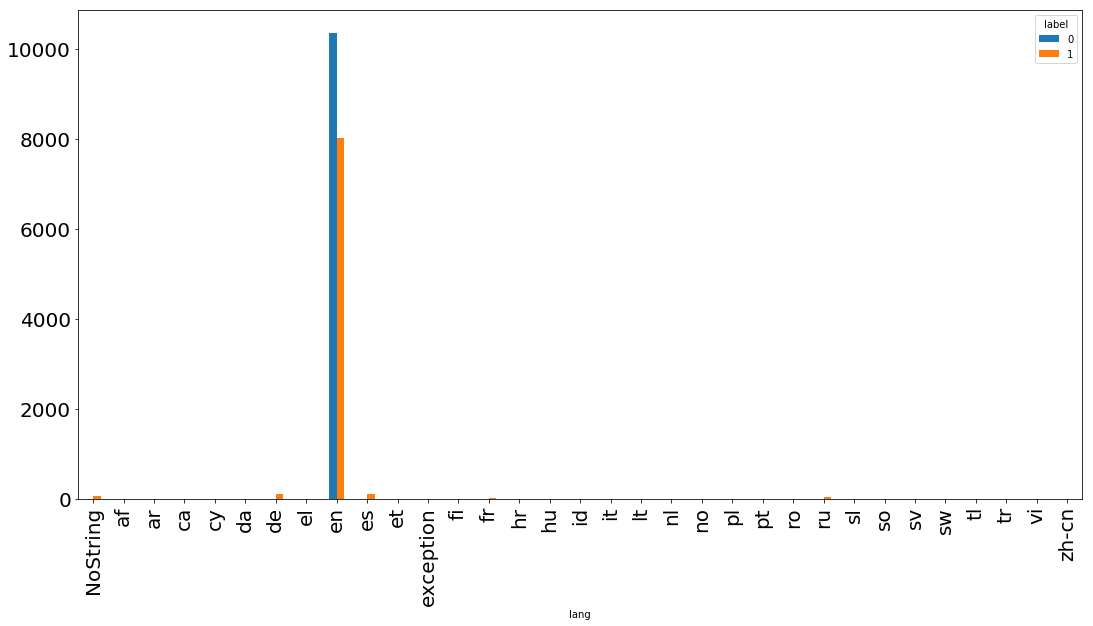

In [27]:
lang_label_summary.pivot(index='lang',columns='label',values='author').plot.bar(fontsize=20,figsize=(18, 9))

In [33]:
#### Test Data summary

test_all_df = pd.read_csv(file_test)

print(test_all_df.shape)
test_all_df.head()

(5200, 4)


,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
